# Домашнее задание №8. Синтез изображений
Постановка задачи: реализовать синтезирование лиц из LFW с помощью DCGAN (Deep Convolutional GAN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

### Загрузка данных

In [2]:
train_ds, info = tfds.load(
    'lfw',
    split='train', # какой размер читать
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompleteTSMV7U/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
# метаданные
info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

In [4]:
len(train_ds)

13233

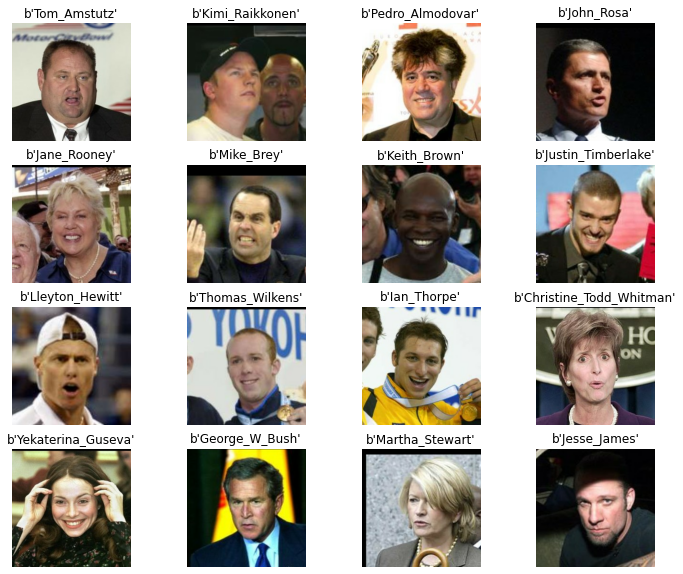

In [5]:
# визуализация датасета

plt.figure(figsize=(12, 10))
for j, (label, image) in enumerate(train_ds.take(16)):
    plt.subplot(4, 4, j+1)
    plt.title(label.numpy()) 
    plt.imshow(image)
    plt.axis('off')

### Подготовка пайплайна для обучения

In [6]:
INPUT_DIM = 100
INP_SIZE = 48
NUM_EPOCHS = 40
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2 # 1 половина батча-> в дискриминатор, 2 половина -> в генератор
LEARNING_RATE = 0.0002

train_ds = train_ds.shuffle(buffer_size=len(train_ds))

# Перводим в даиапазон от -1 до 1 и меняем размер на мЕньший
def preprocessing(img):
  img = (tf.cast(img, tf.float32) - 127.5) / 127.5  #преобразование к значениям [-1;1]
  return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = train_ds.map(lambda label, img: (preprocessing(img), label))
# уточняем количество повторений (эпох)
train_ds = train_ds.repeat(NUM_EPOCHS)
# и размер батча
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [7]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(16, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16,), dtype=tf.string, name=None))>

### Построение DCGAN

In [8]:
# ГЕНЕРАТОР

generator = tf.keras.Sequential([
    
    # UP block 1
    tf.keras.layers.Dense(288*12*12, activation='relu'), #подобран размер, чтобы генерировался нужный размер изобр
    tf.keras.layers.Reshape((12, 12, 288)),
    tf.keras.layers.UpSampling2D((2, 2)),  #(2,2) - ядро свертки = 2, stride = 2  
    tf.keras.layers.Conv2D(288, (3, 3), padding='same'),
    tf.keras.layers.ReLU(),  
    tf.keras.layers.BatchNormalization(momentum=0.8),

    # Conv Block - уменьшаем количество каналов
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.ReLU(), 
    tf.keras.layers.BatchNormalization(momentum=0.8), 
    
    # UP block 2
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])


# generator.build(input_shape = (None, 100))
# generator.summary()

In [9]:
# ДИСКРИМИНАТОР

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

# discriminator.build(input_shape = (None, 48, 48, 3))
# discriminator.summary()

### Обучение генеративной нейронной сети

In [10]:
# Функция для вывода результата

def plot_imgs(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [11]:
#компиляция модели
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.8254; G Loss: 0.6697


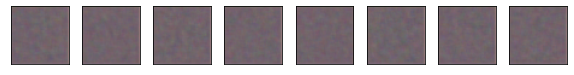

[Step 500] D Loss: 1.7023; G Loss: 1.9247


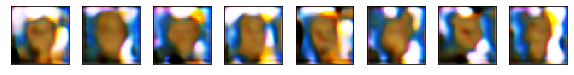

[Step 1000] D Loss: 1.9401; G Loss: 0.3239


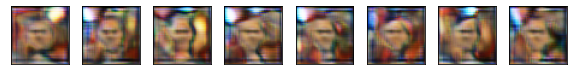

[Step 1500] D Loss: 0.9545; G Loss: 0.9097


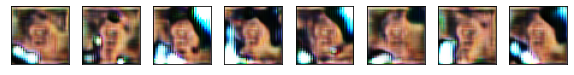

[Step 2000] D Loss: 0.6369; G Loss: 0.3939


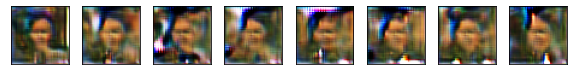

[Step 2500] D Loss: 0.5333; G Loss: 2.1082


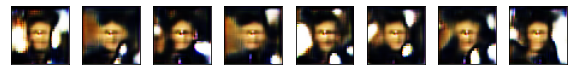

[Step 3000] D Loss: 1.0344; G Loss: 0.2137


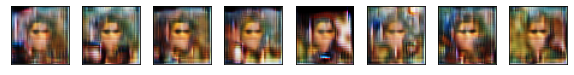

[Step 3500] D Loss: 0.7851; G Loss: 1.3084


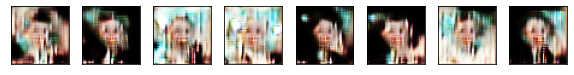

[Step 4000] D Loss: 0.3435; G Loss: 0.8621


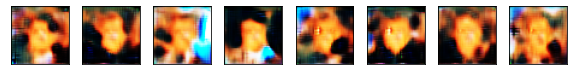

[Step 4500] D Loss: 0.7067; G Loss: 1.3225


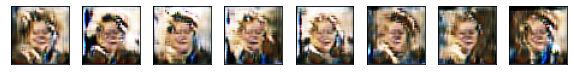

[Step 5000] D Loss: 0.7141; G Loss: 1.8420


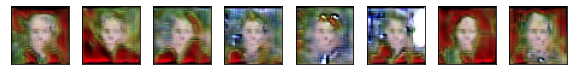

[Step 5500] D Loss: 0.7420; G Loss: 1.1272


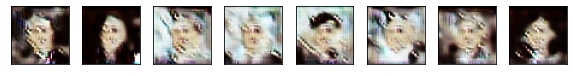

[Step 6000] D Loss: 0.6448; G Loss: 0.9643


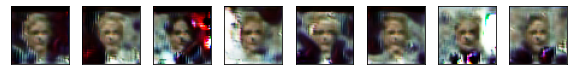

[Step 6500] D Loss: 0.6213; G Loss: 1.3184


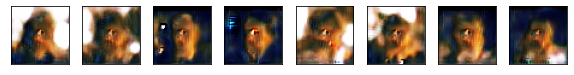

[Step 7000] D Loss: 0.5279; G Loss: 1.3051


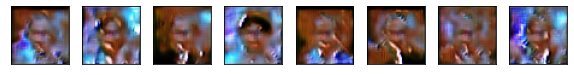

[Step 7500] D Loss: 1.0346; G Loss: 1.3014


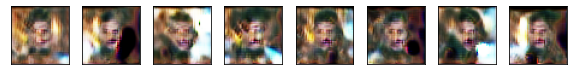

[Step 8000] D Loss: 0.5343; G Loss: 0.5058


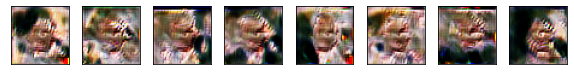

[Step 8500] D Loss: 0.6699; G Loss: 1.4886


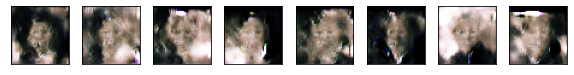

[Step 9000] D Loss: 0.8783; G Loss: 1.0560


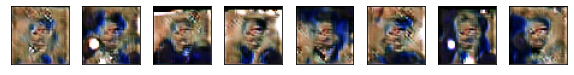

[Step 9500] D Loss: 0.4112; G Loss: 1.2660


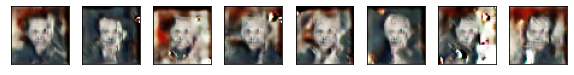

[Step 10000] D Loss: 0.9371; G Loss: 1.3335


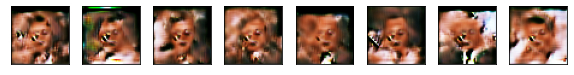

[Step 10500] D Loss: 0.8961; G Loss: 1.0659


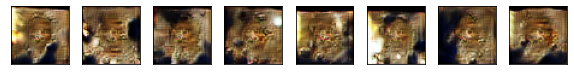

[Step 11000] D Loss: 0.8757; G Loss: 0.6801


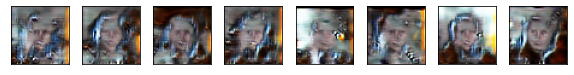

[Step 11500] D Loss: 0.5854; G Loss: 0.7160


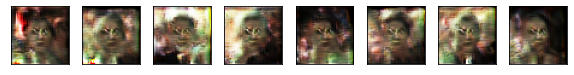

[Step 12000] D Loss: 0.9241; G Loss: 0.7419


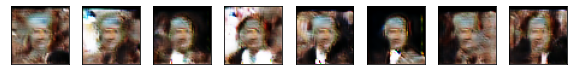

[Step 12500] D Loss: 0.6861; G Loss: 0.5349


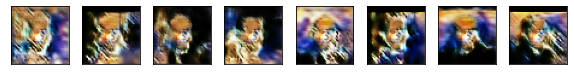

[Step 13000] D Loss: 0.6883; G Loss: 1.1165


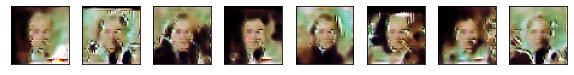

[Step 13500] D Loss: 0.5589; G Loss: 1.1146


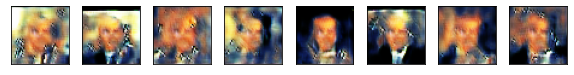

[Step 14000] D Loss: 0.6043; G Loss: 1.4139


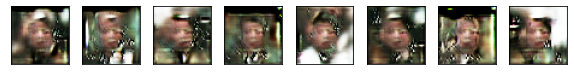

[Step 14500] D Loss: 0.6901; G Loss: 1.1627


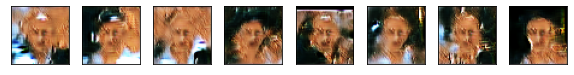

[Step 15000] D Loss: 0.6168; G Loss: 1.2002


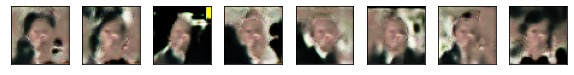

[Step 15500] D Loss: 0.6760; G Loss: 1.0333


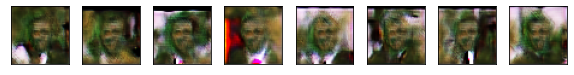

[Step 16000] D Loss: 0.6667; G Loss: 1.1369


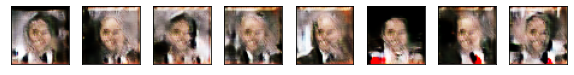

[Step 16500] D Loss: 0.5566; G Loss: 1.0462


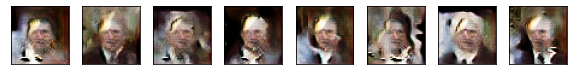

[Step 17000] D Loss: 0.7432; G Loss: 0.9218


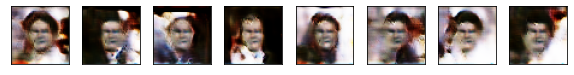

[Step 17500] D Loss: 0.6749; G Loss: 1.0087


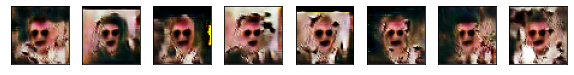

[Step 18000] D Loss: 0.4290; G Loss: 1.4860


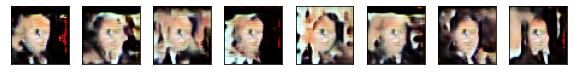

[Step 18500] D Loss: 0.5618; G Loss: 0.9756


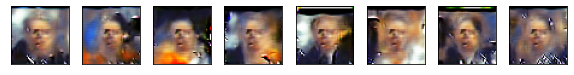

[Step 19000] D Loss: 0.6095; G Loss: 0.9626


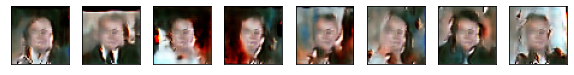

[Step 19500] D Loss: 0.6280; G Loss: 1.0897


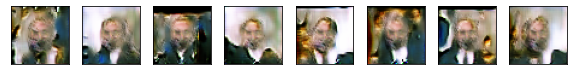

[Step 20000] D Loss: 0.6595; G Loss: 0.7871


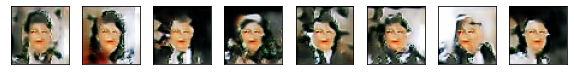

[Step 20500] D Loss: 0.8740; G Loss: 0.8220


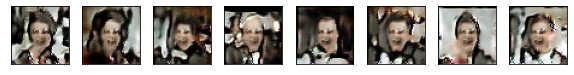

[Step 21000] D Loss: 0.7515; G Loss: 0.7598


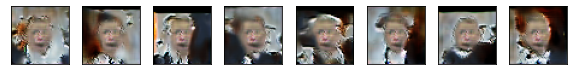

[Step 21500] D Loss: 0.6486; G Loss: 0.9612


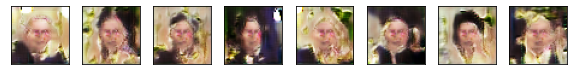

[Step 22000] D Loss: 0.6718; G Loss: 0.7849


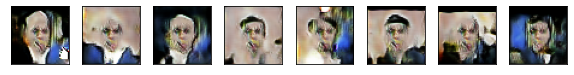

[Step 22500] D Loss: 0.7119; G Loss: 0.6891


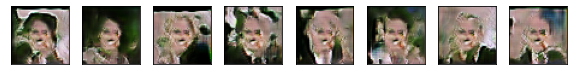

[Step 23000] D Loss: 0.7729; G Loss: 0.8366


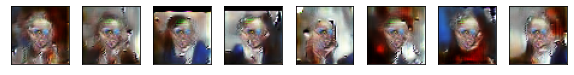

[Step 23500] D Loss: 0.6049; G Loss: 1.0227


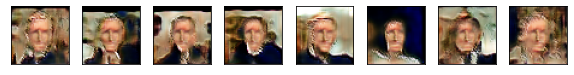

[Step 24000] D Loss: 0.8023; G Loss: 1.0042


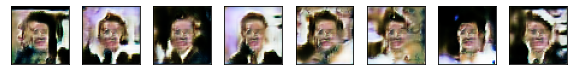

[Step 24500] D Loss: 0.5219; G Loss: 0.9069


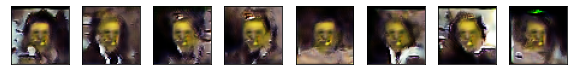

[Step 25000] D Loss: 0.7099; G Loss: 0.9729


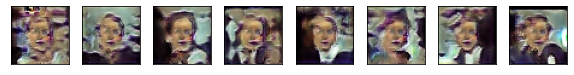

[Step 25500] D Loss: 0.6701; G Loss: 0.8588


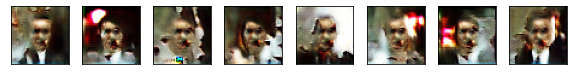

[Step 26000] D Loss: 0.6060; G Loss: 0.9437


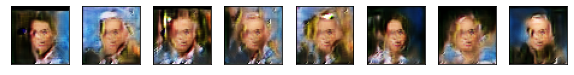

[Step 26500] D Loss: 0.7511; G Loss: 0.8009


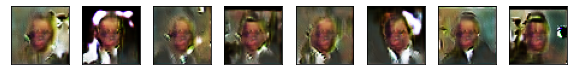

[Step 27000] D Loss: 0.9015; G Loss: 0.6611


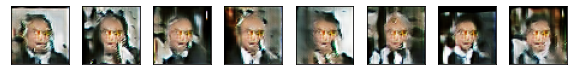

[Step 27500] D Loss: 0.4360; G Loss: 1.2878


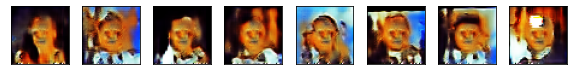

[Step 28000] D Loss: 0.6561; G Loss: 0.9720


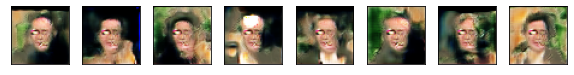

[Step 28500] D Loss: 0.7010; G Loss: 0.8676


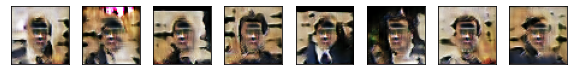

[Step 29000] D Loss: 0.5709; G Loss: 1.0168


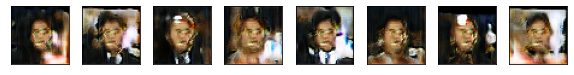

[Step 29500] D Loss: 0.7095; G Loss: 0.8055


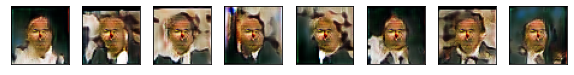

[Step 30000] D Loss: 0.7450; G Loss: 0.7212


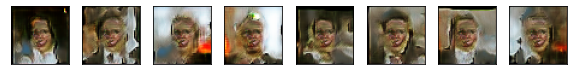

[Step 30500] D Loss: 0.6023; G Loss: 0.8491


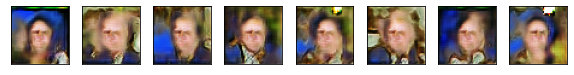

[Step 31000] D Loss: 0.6939; G Loss: 0.8275


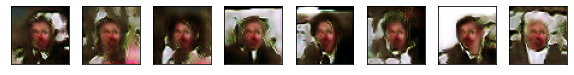

[Step 31500] D Loss: 0.6355; G Loss: 1.0740


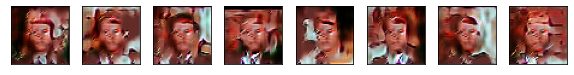

[Step 32000] D Loss: 0.5691; G Loss: 1.1857


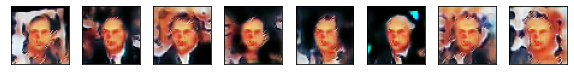

[Step 32500] D Loss: 0.7498; G Loss: 0.7736


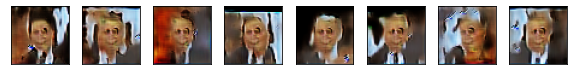

[Step 33000] D Loss: 0.6575; G Loss: 0.7620


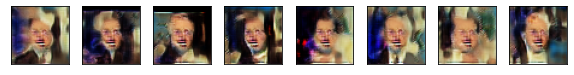

In [12]:
#обучение модели
for step, (true_images, labels) in enumerate(train_ds):
     
    # Train DISCRIMINATOR
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    # объединяем реальные и сгенерированные картинки
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    
    # делаем метки классов
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    

    with tf.GradientTape() as tape:
        # полученный соединенные датасет подаем в дискриминатор, при обновлении весов генератор не трогаем
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train GENERATOR
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        # подаем сгенерированные картинки в дискриминатор, но при обновлении весов него не трогаем (только в дискр обновляем веса!)
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_imgs(syntetic_images)

### Тестирование модели

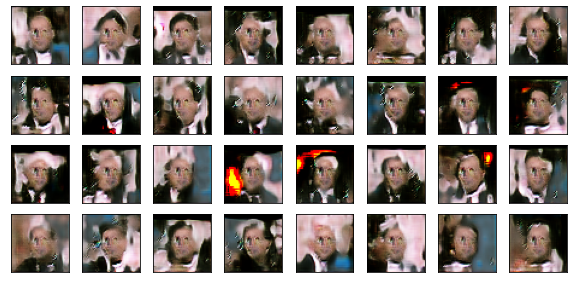

In [13]:
# Создаем рандомный шум в нормальном распределении и передаем его в генератор, ожидая увидеть хорошую картинку
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_imgs(syntetic_images)

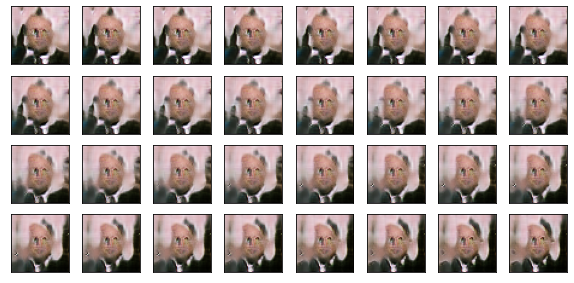

In [15]:
# Интерполияция в латентное пространстве - проверка свойства непрерывности (плавности)
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_imgs(syntetic_images)

Если существенное увеличить число эпох при обучении генеративной модели, предполагаю, что качество будет выше.